In [2]:
#Importing Pandas module
import csv
import pandas as pd



#Import dataset in the form of a dataframe
heart_df = pd.read_csv('heart.csv')

#Looking at the first five rows of the dataset
heart_df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
#Getting shape of the data
heart_df.shape

(299, 13)

In [4]:
#Looking for the null values through the dataset because neural net require non null variables
heart_df.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [5]:
#Importing essential packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


#Splitting data into independant and depedant variables

X = heart_df.drop(columns=['DEATH_EVENT']) #Independant data variables



y_label = heart_df['DEATH_EVENT'].values.reshape(X.shape[0], 1) #Dependant or target variable

#Split data into train and test set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_label, test_size=0.2, random_state=2)

#Standardize the dataset
sc = StandardScaler()
sc.fit(Xtrain)
Xtrain = sc.transform(Xtrain)
Xtest = sc.transform(Xtest)

print(f"Shape of train set is {Xtrain.shape}")
print(f"Shape of test set is {Xtest.shape}")
print(f"Shape of train label is {ytrain.shape}")
print(f"Shape of test labels is {ytest.shape}")

Shape of train set is (239, 12)
Shape of test set is (60, 12)
Shape of train label is (239, 1)
Shape of test labels is (60, 1)


In [6]:

class NeuralNet():
    '''
    A two layer neural network
    '''
        
    def __init__(self, layers=[12,6,1], learning_rate=0.001, iterations=100):
        self.params = {}
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.loss = []
        self.sample_size = None
        self.layers = layers
        self.X = None
        self.y = None
                
    def init_weights(self):
        '''
        Initialize the weights from a random normal distribution
        '''
        np.random.seed(1) # Seed the random number generator
        self.params["W1"] = np.random.randn(self.layers[0], self.layers[1]) 
        self.params['b1']  =np.random.randn(self.layers[1],)
        self.params['W2'] = np.random.randn(self.layers[1],self.layers[2]) 
        self.params['b2'] = np.random.randn(self.layers[2],)
        
    def relu(self,Z):
        '''
        The ReLu activation function is to performs a threshold
        operation to each input element where values less 
        than zero are set to zero.
        '''
        return np.maximum(0,Z)
    
    def sigmoid(self,Z):
        '''
        The sigmoid function takes in real numbers in any range and 
        squashes it to a real-valued output between 0 and 1.
        '''
        return 1.0/(1.0+np.exp(-Z))
    
    def entropy_loss(self,y, yhat):
        nsample = len(y)
        loss = -1/nsample * (np.sum(np.multiply(np.log(yhat), y) + np.multiply((1 - y), np.log(1 - yhat))))
        return loss
    
    def forward_propagation(self):
        '''
        Performs the forward propagation
        '''
        
        Z1 = self.X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        yhat = self.sigmoid(Z2)
        loss = self.entropy_loss(self.y,yhat)

        # save calculated parameters     
        self.params['Z1'] = Z1
        self.params['Z2'] = Z2
        self.params['A1'] = A1

        return yhat,loss
    
    def back_propagation(self,yhat):
        '''
        Computes the derivatives and update weights and bias according.
        '''
        def dRelu(x):
            x[x<=0] = 0
            x[x>0] = 1
            return x
        
        dl_wrt_yhat = -(np.divide(self.y,yhat) - np.divide((1 - self.y),(1-yhat)))
        dl_wrt_sig = yhat * (1-yhat)
        dl_wrt_z2 = dl_wrt_yhat * dl_wrt_sig

        dl_wrt_A1 = dl_wrt_z2.dot(self.params['W2'].T)
        dl_wrt_w2 = self.params['A1'].T.dot(dl_wrt_z2)
        dl_wrt_b2 = np.sum(dl_wrt_z2, axis=0)

        dl_wrt_z1 = dl_wrt_A1 * dRelu(self.params['Z1'])
        dl_wrt_w1 = self.X.T.dot(dl_wrt_z1)
        dl_wrt_b1 = np.sum(dl_wrt_z1, axis=0)
        
        #update the weights and bias
        self.params['W1'] = self.params['W1'] - self.learning_rate * dl_wrt_w1
        self.params['W2'] = self.params['W2'] - self.learning_rate * dl_wrt_w2
        self.params['b1'] = self.params['b1'] - self.learning_rate * dl_wrt_b1
        self.params['b2'] = self.params['b2'] - self.learning_rate * dl_wrt_b2
        
    
    def fit(self, X, y):
        '''
        Trains the neural network using the specified data and labels
        '''
        self.X = X
        self.y = y
        self.init_weights() #initialize weights and bias


        for i in range(self.iterations):
            yhat, loss = self.forward_propagation()
            self.back_propagation(yhat)
            self.loss.append(loss)
            
    def predict(self, X):
        '''
        Predicts on a test data
        '''
        Z1 = X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        pred = self.sigmoid(Z2)
        return np.round(pred) 
    
    def acc(self, y, yhat):
        '''
        Calculates the accuracy between the predicted value and the truth labels
        '''
        acc = int(sum(y == yhat) / len(y) * 100)
        return acc


    def plot_loss(self):
        '''
        Plots the loss curve
        '''
        plt.plot(self.loss)
        plt.xlabel("Iteration")
        plt.ylabel("logloss")
        plt.title("Loss curve for training")
        plt.show()

In [7]:
#Create object of class Neural net
nn = NeuralNet(layers=[12,6,1], learning_rate=0.001, iterations=100) # create the NN model

#Fit the train dataset to this object - training the model
nn.fit(Xtrain, ytrain) #train the model

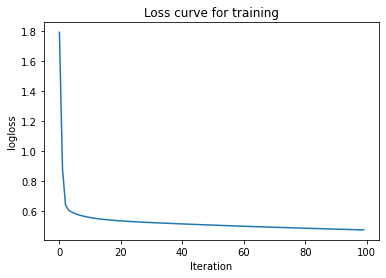

In [8]:
#Plot the loss 
nn.plot_loss()

In [9]:
#Predict the train and test data 
train_pred = nn.predict(Xtrain)
test_pred = nn.predict(Xtest)

#Calculate the accuracy of the train and test datasets
print("Train accuracy is {}".format(nn.acc(ytrain, train_pred)))
print("Test accuracy is {}".format(nn.acc(ytest, test_pred)))

Train accuracy is 78
Test accuracy is 90
